# This notebook analysis the isomerization time scale of hte EE trajs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pickle
import pandas as pd

In [2]:
class Data:
    def __init__(self, array_list):
        self.array_list = array_list

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self.array_list, f)

    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            array_list = pickle.load(f)
        return cls(array_list)

In [3]:
def omega2cistrans(omega):
    """Converts a sequence of float omega angles (in degrees) to an array of ints: 0 cis and 1 trans."""
    
    shifted_omega = (omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    return cistrans

In [4]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
#all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array
all_omega = Data.load(f"{save_dir}/omega_state0.pkl").array_list  # This is an (85, x, 3) array


In [5]:
ntraj = len(all_omega)
all_cistrans = []
for i in range(ntraj):
    all_cistrans.append(omega2cistrans(all_omega[i]))

all_cistrans

# Find the longest traj
maxlength = max( [ len(all_cistrans[i]) for i in range(ntraj) ])
print('maxlength', maxlength)

# Make an array to store all the trajectories
traj = np.nan * np.ones( (ntraj, maxlength, 3) )

for i in range(ntraj):
    n = len(all_cistrans[i])
    traj[i, 0:n, :] = all_cistrans[i]


traj

maxlength 9234


array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       ...,

       [[ 1.,  1.,  1.],
        [ 0.,  1.,  0.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]],

       [[ 1.,  1.,  1.],
        [ 0.,  1.,  1.],
        [ 0.,  1.,  1.],
        ...,
        [nan, nan, nan],
        [nan, nan, nan],
        [nan, nan, nan]]

In [6]:
# Compute the average over all trajectories for non-nan entries

n_included = np.sum(np.where(np.isnan(traj[:,:,:]), 0, 1), axis=0)
print('n_included', n_included, 'n_included.shape', n_included.shape)

p_trans = np.nanmean(traj, axis=0)
p_trans_std = ((np.nanvar(traj, axis=0)) / (n_included-1))**0.5

print('p_trans', p_trans )
print('p_trans_std', p_trans_std)

n_included [[85 85 85]
 [85 85 85]
 [85 85 85]
 ...
 [ 1  1  1]
 [ 1  1  1]
 [ 1  1  1]] n_included.shape (9234, 3)
p_trans [[1.         1.         1.        ]
 [0.77647059 0.82352941 0.95294118]
 [0.75294118 0.78823529 0.89411765]
 ...
 [0.         0.         1.        ]
 [0.         0.         1.        ]
 [1.         0.         1.        ]]
p_trans_std [[0.         0.         0.        ]
 [0.04545589 0.04159452 0.02310542]
 [0.04705882 0.04457744 0.0335714 ]
 ...
 [       nan        nan        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_68631/774145360.py:7: RuntimeWarning: invalid value encountered in divide
  p_trans_std = ((np.nanvar(traj, axis=0)) / (n_included-1))**0.5


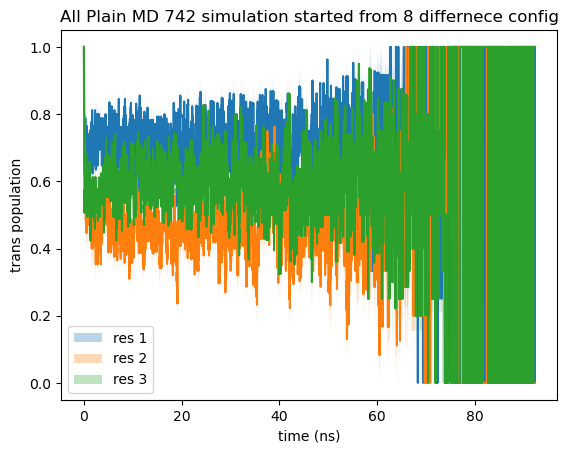

In [7]:
plt.figure()

ns_per_step = 0.01
time_in_ns = np.arange(maxlength)*ns_per_step

plt.plot(time_in_ns, p_trans) # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,0], (p_trans-p_trans_std)[:,0], alpha=0.3, lw=1, label='res 1') # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,1], (p_trans-p_trans_std)[:,1], alpha=0.3, lw=1, label='res 2') # all three residues
plt.fill_between(time_in_ns, (p_trans+p_trans_std)[:,2], (p_trans-p_trans_std)[:,2], alpha=0.3, lw=1, label='res 3') # all three residues
plt.xlabel('time (ns)')
plt.ylabel('trans population')
plt.title('All Plain MD 742 simulation started from 8 differnece config')

plt.legend(loc='best')

### Load in the omega angle trajectories by result

In [8]:
# Parameters
residues_to_plot = [0, 1, 2]  # Residues to plot
num_residues = len(residues_to_plot)

omegas_by_result = []  # To store processed omega data
save_dir = 'omega_data'
all_omega = Data.load(f"{save_dir}/all_omega.pkl").array_list  # This is an (85, x, 3) array


## Convert the omega angle trajectories to cis(0)/trans(1) trajectories 

In [9]:
cistrans_by_replica = []

for i, individual_omega in enumerate(all_omega):
    nsnaps, res = individual_omega.shape
    #print(individual_omega.shape)
    shifted_omega = (individual_omega + 90.0) % 360.0 - 90.0 # shift into (-90, 270) range to avoid periodic boundaries
    
    cistrans = np.where(shifted_omega > 90.0, 1, 0).astype(int)
    cistrans_by_replica.append(cistrans)
    
print(cistrans_by_replica)
print()


[array([[1, 1, 1],
       [0, 1, 1],
       [0, 1, 1],
       ...,
       [0, 1, 1],
       [0, 0, 1],
       [0, 0, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 1, 0],
       [1, 1, 0],
       [1, 1, 0]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]]), array([[1, 1, 1],
       [1, 0, 1],
       [1, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]]), array([[1, 1, 1],
       [1, 0, 0],
       [1, 0, 1],
       ...,
       [1, 0, 0],
       [1, 0, 1],
       [1, 0, 1]]), array([[1, 1, 1],
       [1, 0, 0],
       [1, 0, 0],
       ...,
       [0, 1, 1],
       [0, 1, 1],
       [0, 1, 1]]), array([[1, 1, 1],
       [1, 1, 1],
       [1, 1, 1],
       ...,
       [0, 0, 0],
       [1, 0, 0],
       [1, 0, 0]]), array([[1, 1, 1],
       [1, 0, 1],
       [1, 0, 1],
       ...,
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]]), array([[1, 1, 1],
     

In [13]:
def get_transition_matrix(cistrans_traj, lagtime=10, sliding_window=True, pseudocount=0.25):
    """Returns a row-normalized transiton matrix T for a given lagtime (in steps)."""

    C = np.zeros( (2,2) )   # count matrix
    T = np.zeros( (2,2) )   # transition matrix
    
    N = len(cistrans_traj)  # the length of the trajectory
    for t in range(0, N-lagtime):
        C[cistrans_traj[t],cistrans_traj[t+lagtime]] += 1.0

    # add pseudocounts to avoid zero entries
    C += pseudocount    
    
    # row-normalize
    T[0,:] = C[0,:]/C[0,:].sum()
    T[1,:] = C[1,:]/C[1,:].sum()

    return T

def implied_timesale(T, lagtime=1):
    """Return the implied timescale, in units of number of steps.
    
    INPUT
    T       - transition matrix where T_ij is prob of transitioning i -> j in lagtime.
    
    PARAMETERS
    lagtime - lagtime used to build T (in units of steps). Default = 1
    
    RETURN
    t2      - the implied timescale (in units of steps)
    """
    try:
        evals = np.linalg.eigvals( T.transpose() )  # will be something like [0.99754545 1.        ]
        evals_sorted = np.sort(evals)      # ascending order
        mu2 = evals_sorted[-2]            # second-largest eigenvalue
        # print('mu2', mu2, 'evals', evals, 'T', T)
        t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation
    except:
        t2 = np.nan
        
    return t2
    

lagtimes = [1, 10, 25, 50, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100, 20100, 21100, 22100, 23100, 24100, 25100, 26100, 27100, 28100, 29100, 30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_68631/3493494940.py:37: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation


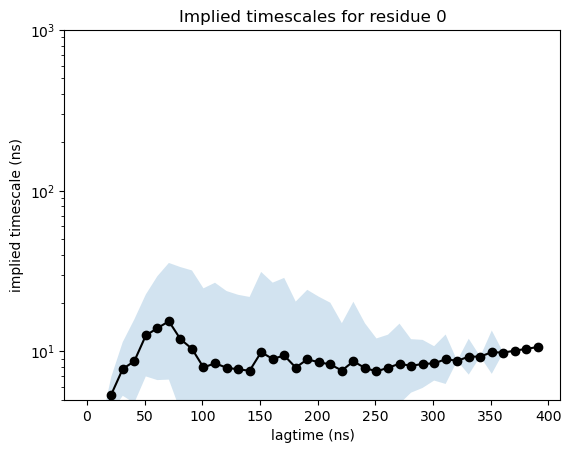

lagtimes = [1, 10, 25, 50, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100, 20100, 21100, 22100, 23100, 24100, 25100, 26100, 27100, 28100, 29100, 30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_68631/3493494940.py:37: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation


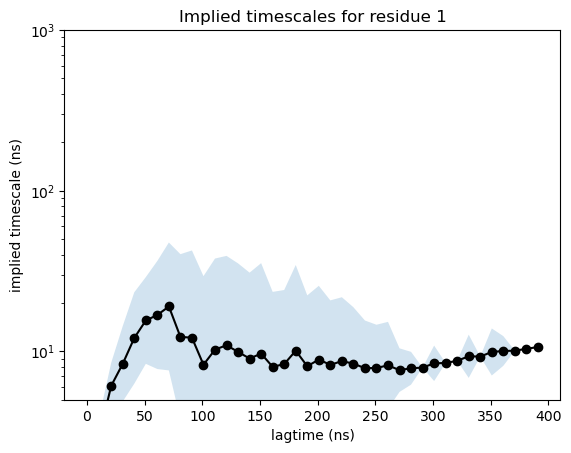

lagtimes = [1, 10, 25, 50, 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100, 10100, 11100, 12100, 13100, 14100, 15100, 16100, 17100, 18100, 19100, 20100, 21100, 22100, 23100, 24100, 25100, 26100, 27100, 28100, 29100, 30100, 31100, 32100, 33100, 34100, 35100, 36100, 37100, 38100, 39100]


/var/folders/2g/yfyfpy7d3n3fwl_23ytkftvm0000gn/T/ipykernel_68631/3493494940.py:37: RuntimeWarning: invalid value encountered in log
  t2 = -1.0*lagtime/np.log(mu2.real)  # the implied timescale relation


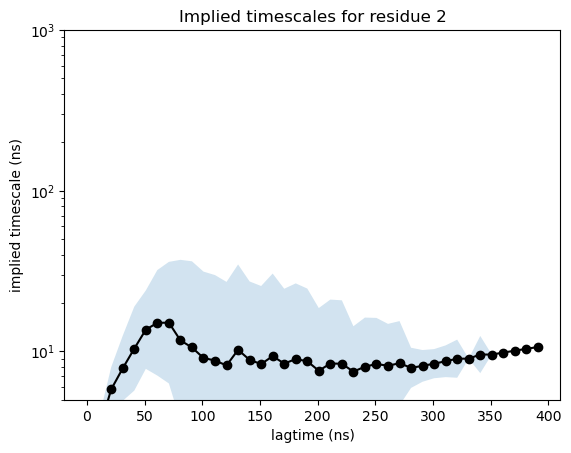

In [14]:
dt_in_ns = 0.01
residues = [0,1,2]
n_result = len(all_omega) # 85 run 

for residue in residues:
    
    lagtimes = [1, 10, 25, 50] + list(range(100, 40000, 1000))
    print('lagtimes =', lagtimes)
    
    t2_means = []  # mean timescales for each lagtime
    t2_uppers  = []  # upperlim of standard deviation of log t2 for each lagtime
    t2_lowers  = []  # lowerlim
    
    for lagtime in lagtimes:
    
        # Each replica is a separate data set we can use for uncertainty estimation
        logt2_values = []    
        for i in range(n_result):
            T = get_transition_matrix(cistrans_by_replica[i][:,residue], lagtime=lagtime)
            logt2_values.append(np.log(implied_timesale(T, lagtime=lagtime)))
        logt2_values = np.array(logt2_values)    
        Ind = ~np.isnan(logt2_values)
        t2_means.append( np.exp(np.mean(logt2_values[Ind] ) ))
        t2_uppers.append( np.exp( np.mean(logt2_values[Ind] ) + np.std(logt2_values[Ind]) ))
        t2_lowers.append( np.exp( np.mean(logt2_values[Ind] ) - np.std(logt2_values[Ind]) ))
    
    t2_means = np.array(t2_means)
    t2_uppers = np.array(t2_uppers)
    t2_lowers = np.array(t2_lowers)
    lagtimes  = np.array(lagtimes)
    
    plt.figure()
    plt.plot(lagtimes*dt_in_ns, t2_means*dt_in_ns, 'ko-')
    plt.fill_between(lagtimes*dt_in_ns, t2_uppers*dt_in_ns, t2_lowers*dt_in_ns, alpha=0.2)
    plt.xlabel('lagtime (ns)')
    plt.ylabel('implied timescale (ns)')
    plt.ylim(5,1000)
    plt.yscale('log')
    plt.title(f'Implied timescales for residue {residue}')
    plt.show()
    